# load, process, and grid ERDDAP 

An attempt make the real-time glider data easier to work with. Once its in this format, it should be easy to grab sections using the `.sel(date = slice() )` methods of xarray. You should also have an easier time calcuating stuff, and plotting agaist time, lat or lon

This is a little fast and loose, so caveat emptor for science!

## to do:
We could(should) just convert this into a function to be run by another notebook. 
input to that function would probably be the glider dataset ID, and the variables you want

In [1]:
import xarray as xr
import pandas as pd
from erddapy import ERDDAP
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

import numpy as np

from scipy.signal import find_peaks

from scipy import stats

In [2]:
# this creates a link to the RUCOOL server:
e = ERDDAP(
    server="http://slocum-data.marine.rutgers.edu/erddap",
    protocol="tabledap",
    response="nc",
)

# get the science data:
e.dataset_id = 'ru29-20200908T1623-profile-sci-rt'

# this connects to the data and load into an pandas dataframe
ds = e.to_pandas()
# remove the spaces from the column names
ds.columns = ds.columns.str.split(' ').str[0]

# get the time to be a datetime object
ds['time'] = pd.to_datetime(ds['time'])

# put the times in order
ds = ds.sort_values(by=['time'])

print(ds.info())

ds.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 663553 entries, 0 to 663552
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype              
---  ------                         --------------   -----              
 0   time                           663553 non-null  datetime64[ns, UTC]
 1   latitude                       663553 non-null  float64            
 2   longitude                      663553 non-null  float64            
 3   depth                          375538 non-null  float64            
 4   trajectory                     663553 non-null  object             
 5   source_file                    663553 non-null  object             
 6   beta_700nm                     165880 non-null  float64            
 7   cdom                           165882 non-null  float64            
 8   chlorophyll_a                  165882 non-null  float64            
 9   conductivity                   375503 non-null  float64            
 10  crs     

,time,latitude,longitude,depth,trajectory,source_file,beta_700nm,cdom,chlorophyll_a,conductivity,...,sci_ad2cp_run_state,sci_ad2cp_surface_state,sci_m_disk_free,sci_m_present_time,sci_water_pressure,sound_speed,temperature,u,v,water_depth
0,2020-09-08 16:28:35+00:00,18.177151,-64.805848,6.291905,ru29-20200908T1623,ru29-2020-251-4-0-sbd(04270000),0.000110,0.7208,0.0648,5.78587,...,5.0,0.0,NaN,2020-09-08T16:28:35Z,0.633,1544.6094,29.6361,NaN,NaN,NaN
1,2020-09-08 16:28:47+00:00,18.177142,-64.805823,8.319587,ru29-20200908T1623,ru29-2020-251-4-0-sbd(04270000),0.000110,0.8109,0.0864,5.78270,...,NaN,NaN,NaN,2020-09-08T16:28:47Z,0.837,1544.5654,29.5950,NaN,NaN,NaN
2,2020-09-08 16:28:59+00:00,18.177132,-64.805798,10.963495,ru29-20200908T1623,ru29-2020-251-4-0-sbd(04270000),0.000139,1.1713,0.1008,5.78063,...,NaN,NaN,NaN,2020-09-08T16:28:59Z,1.103,1544.5435,29.5569,NaN,NaN,NaN
3,2020-09-08 16:29:12+00:00,18.177123,-64.805773,13.557673,ru29-20200908T1623,ru29-2020-251-4-0-sbd(04270000),0.000115,0.7208,0.0936,5.78405,...,NaN,NaN,NaN,2020-09-08T16:29:12Z,1.364,1544.5581,29.5177,NaN,NaN,NaN
4,2020-09-08 16:29:24+00:00,18.177113,-64.805748,16.181635,ru29-20200908T1623,ru29-2020-251-4-0-sbd(04270000),0.000112,1.6218,0.1008,5.79035,...,NaN,NaN,NaN,2020-09-08T16:29:24Z,1.628,1544.6151,29.4944,NaN,NaN,NaN


(0.0, 10000.0)

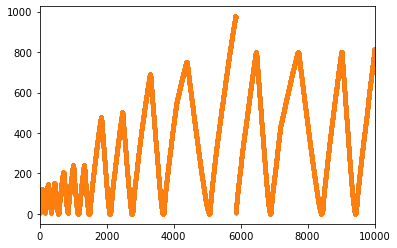

In [3]:

# fill nans in depth for the profile breakup
interpd = ds.depth.interpolate()

plt.plot(ds.depth.values, '.')
plt.plot(interpd.values, '.')  
plt.xlim([0, 1e4])



In [4]:
# find the top and bottom of each profile
apogee, prop = find_peaks(interpd.values,  threshold=None, 
                          distance=None, prominence=50)

perogee, prop = find_peaks(-1*interpd.values,  threshold=None, 
                           distance=None, prominence=50)

# stack the index of the turning points into one vector
turns = np.sort(np.append(apogee, perogee ))
turns.shape

(937,)

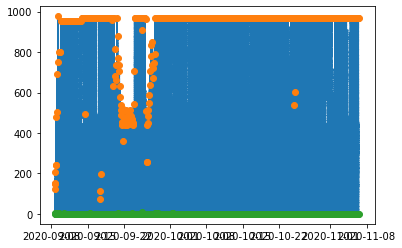

In [5]:
# check your work
plt.plot(ds.time, ds.depth)
plt.plot(ds.time[apogee], ds.depth[apogee], 'o')
plt.plot(ds.time[perogee], ds.depth[perogee], 'o')


(0.0, 10000.0)

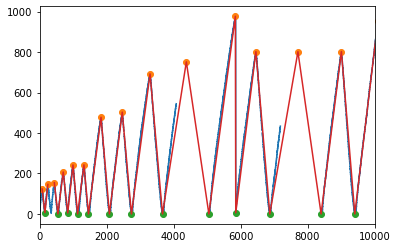

In [6]:
# look in more detail
plt.plot( ds.depth)
plt.plot( ds.depth[apogee], 'o')
plt.plot( ds.depth[perogee], 'o')
plt.plot( ds.depth[turns])
plt.xlim([0, 1e4 ])

# plt.xlim([4.2e5, 4.5e5 ])

# GRID!

build a useful dataset for analysis. We will grid some stuff in time and depth, then grid some 1-d stuff to make coordinates and put it all together into an xarray dataset

## start with '2D' gridding

here we are going to bin (grid) stuff that has 2 dimentions: time and depth

for example: temp, salin, ...

In [7]:
# this is your depth grid, you can set:
zgrd = np.arange(0,1000,5)

# list of variables to grid in 2d:
# you choose from the columns of the science data
# this should be the input to a function you create
dataz = ['potential_temperature', 'salinity', 
         'cdom', 'chlorophyll_a', 'beta_700nm']


# this is a dict to hold our gridded stuff
# until we make a dataset later
d2 = {}

# loop on the variables you want to bin
for varz in dataz:    
    values = ds[varz] # grab this data
    
    #this thing below bins the data
    ret = stats.binned_statistic_2d(ds.index.values, ds.depth, 
                                    values, statistic='mean', bins=[ turns, zgrd ])
    d2[varz] = ret.statistic.T
    
d2.keys()

dict_keys(['potential_temperature', 'salinity', 'cdom', 'chlorophyll_a', 'beta_700nm'])

(199, 936)

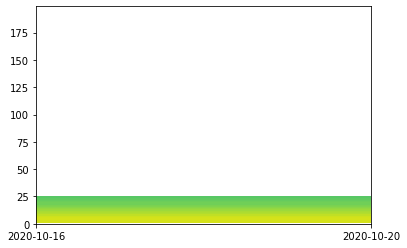

In [21]:
# make a quick plot of the results
plt.pcolormesh(d2['potential_temperature'] )
# plt.xlim([0, 40])


d2['potential_temperature'].shape

## next: bin some '1D' stuff
these are things that dont have a depth dimention:
like, time, lat, lon, u, v, ...

In [9]:
# things to bin in the x direction
# these also prob need defn in the function call
oneDvars = ['latitude','longitude', 'time', 'u', 'v']

# NB: u, v only have one value per dive sequence, so only half the number profiles!
# actually, its weirder than that... not sure there are more than half...

# dict to hold our 1d bins
d1 = {}

# loop on 1d stuff:
for thing in oneDvars:    
    # time variable needs to be treated a little differently
    if thing == 'time':
        bin_means, bin_edges, binnumber = stats.binned_statistic(ds.index.values,
                    ds[thing].astype(int), statistic = 'mean', bins=turns)
        bin_means = pd.to_datetime(bin_means)
        
    # if we aren't binning time, things are normal
    else:
    
        bin_means, bin_edges, binnumber = stats.binned_statistic(ds.index.values,
                    ds[thing].values, statistic = np.nanmean, bins=turns)
    d1[thing] = bin_means
    
d1.keys()

/Users/beaird/anaconda3/envs/fm2020/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:631: RuntimeWarning: Mean of empty slice
  result[vv, i] = statistic(values[vv, binnumbers == i])
/Users/beaird/anaconda3/envs/fm2020/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:631: RuntimeWarning: Mean of empty slice
  result[vv, i] = statistic(values[vv, binnumbers == i])


dict_keys(['latitude', 'longitude', 'time', 'u', 'v'])

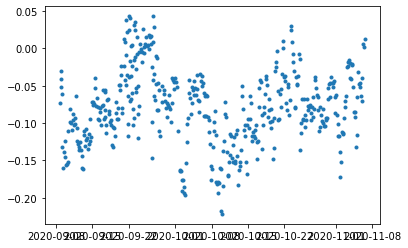

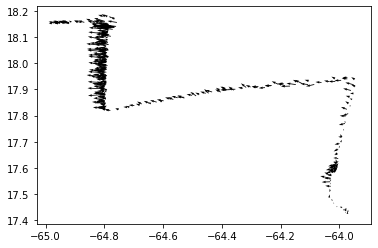

In [10]:
# check out work
plt.plot(d1['time'], d1['u'],'.')

plt.figure()
plt.quiver(d1['longitude'], d1['latitude'], d1['u'], d1['v'])

457  non-nan velocites


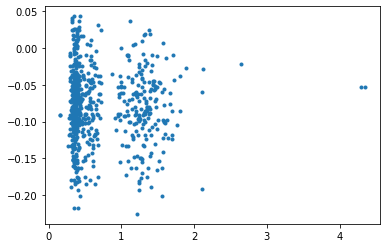

In [11]:
# how many non-nan u and v's?
# this is confusing
# also, this is not a main issue right now, but needs attention
print( np.count_nonzero( ~np.isnan(d1['v']) ) , ' non-nan velocites')

# this plot shows us that the velocity values are reported near the surface 
plt.plot(interpd.values, ds.u.values, '.')

# put it all together

Now we can add these things together into an xarray dataset that will be easier to work with.

We've created 2D data, and some dims / coords to go with the data

In [12]:
# need the depth grid centers
zgrd_ctr = zgrd[:-1] + np.diff(zgrd).mean()/2

# create the dataset
ds_gridded = xr.Dataset( coords = {
                           'date': d1['time'].values,
                           'depth': zgrd_ctr ,
                           'lat': ('date', d1['latitude']),
                           'lon': ('date', d1['longitude'])
                          },
               data_vars = {'u': ('date', d1['u']), 
                           'v': ('date', d1['v'])})

# add the other data in a loop

for varz in d2.keys():
    ds_gridded[varz] = ( ('depth', 'date'),d2[varz] )

    
# thie line below will save the netcdf if you want to work with it in another notebook    
# ds_gridded.to_netcdf('./glider_gridded.nc')

ds_gridded


<xarray.Dataset>
Dimensions:                (date: 936, depth: 199)
Coordinates:
  * date                   (date) datetime64[ns] 2020-09-08T16:45:31.84337305...
  * depth                  (depth) float64 2.5 7.5 12.5 ... 982.5 987.5 992.5
    lat                    (date) float64 18.18 18.18 18.18 ... 17.85 17.83
    lon                    (date) float64 -64.8 -64.81 -64.8 ... -64.8 -64.8
Data variables:
    u                      (date) float64 nan nan nan ... 0.002039 nan 0.01299
    v                      (date) float64 nan nan nan ... 0.03152 nan 0.03258
    potential_temperature  (depth, date) float64 nan nan nan nan ... nan nan nan
    salinity               (depth, date) float64 nan nan nan nan ... nan nan nan
    cdom                   (depth, date) float64 nan nan nan nan ... nan nan nan
    chlorophyll_a          (depth, date) float64 nan nan nan nan ... nan nan nan
    beta_700nm             (depth, date) float64 nan nan nan nan ... nan nan nan

(1000.0, 0.0)

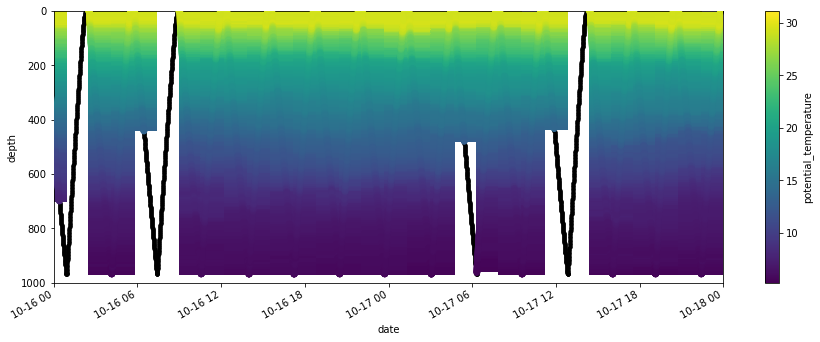

In [28]:
# make a simple plot
plt.figure(figsize=(15,5))
ds_gridded.potential_temperature.plot( yincrease=False)
# ds_gridded.chlorophyll_a.plot( yincrease = False)

plt.plot(ds.time, ds.depth, 'k.', zorder=2)

plt.scatter(ds.time, ds.depth, c=ds.potential_temperature, zorder=10)

plt.xlim(['2020-10-16', '2020-10-18'])

# plt.pcolormesh( ds_gridded.lat, ds_gridded.depth, 
#                ds_gridded.potential_temperature )
plt.ylim([1000, 0])

# make a section plot
this should be easier now, but this belongs in another notebook

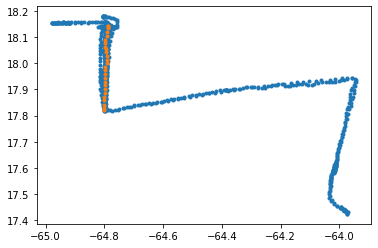

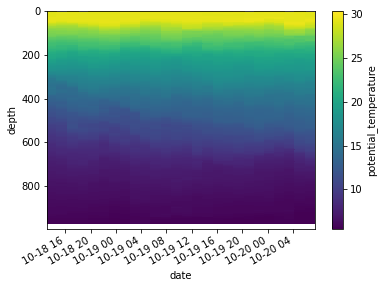

In [14]:
# can we select a time?
section = ds_gridded.sel( date = 
                         slice('2020-10-18T13:04:29.446530048','2020-10-20T07:42:28.419889920' ) )

plt.figure()
plt.plot(ds_gridded.lon, ds_gridded.lat,'.')
plt.plot(section.lon, section.lat,'.')

plt.figure()
section.potential_temperature.plot( yincrease=False)

In [15]:
ds_gridded

<xarray.Dataset>
Dimensions:                (date: 936, depth: 199)
Coordinates:
  * date                   (date) datetime64[ns] 2020-09-08T16:45:31.84337305...
  * depth                  (depth) float64 2.5 7.5 12.5 ... 982.5 987.5 992.5
    lat                    (date) float64 18.18 18.18 18.18 ... 17.85 17.83
    lon                    (date) float64 -64.8 -64.81 -64.8 ... -64.8 -64.8
Data variables:
    u                      (date) float64 nan nan nan ... 0.002039 nan 0.01299
    v                      (date) float64 nan nan nan ... 0.03152 nan 0.03258
    potential_temperature  (depth, date) float64 nan nan nan nan ... nan nan nan
    salinity               (depth, date) float64 nan nan nan nan ... nan nan nan
    cdom                   (depth, date) float64 nan nan nan nan ... nan nan nan
    chlorophyll_a          (depth, date) float64 nan nan nan nan ... nan nan nan
    beta_700nm             (depth, date) float64 nan nan nan nan ... nan nan nan

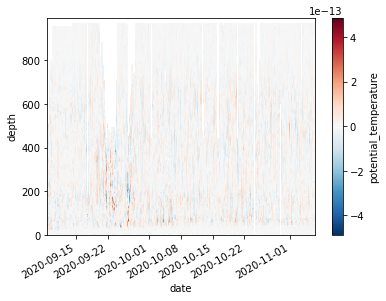

In [16]:

# dT/dTIME = 
ds_gridded.potential_temperature.differentiate('date').plot()